### Answer(1): 4

### Answer(2): 1

In [1]:
#!pip install watermark
%load_ext watermark

In [3]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn 

CPython 3.6.7
IPython 6.5.0

numpy 1.15.4
scipy 1.1.0
pandas 0.23.4
matplotlib 3.0.2
sklearn 0.20.0

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [2]:
from collections import defaultdict
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from IPython.display import clear_output

pd.set_option('display.float_format', lambda x: '{:g}'.format(x))
np.set_printoptions(suppress=True)
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12

Let's load and preprocess our dataset. Change paths to data files if needed.

In [3]:
df = pd.read_csv('../data/stackoverflow_sample_70k.csv.zip')

In [3]:
df.head()

,question,tags
0,i ve got some code in window scroll that check...,javascript jquery
1,i have a custom adapter for a list view it has...,android
2,in my form panel i added a checkbox setting st...,javascript
3,i have the two dates variables startwork and e...,c#
4,i might have been using the wrong search tags ...,android


Top tags on StackOverflow for these 70k questions are the following:

In [4]:
top_tags = ['python', 'ios', 'html', 'android', 'c++', 'jquery', 'java', 'php', 'c#', 'javascript']

`question` and `tags` are strings, so we need to preprocess them.

Preprocessing steps will be as follows:

- convert to lowercase
- strip whitespaces
- split by whitespaces to form a list of words



In [5]:
%%time
df['tags'] = df['tags'].str.lower()\
                       .str.strip()\
                       .str.split(' ')
df['question'] = df['question'].str.lower()\
                               .str.strip()\
                               .str.split(' ')

Wall time: 1.53 s


In [6]:
df.head()

,question,tags
0,"[i, ve, got, some, code, in, window, scroll, t...","[javascript, jquery]"
1,"[i, have, a, custom, adapter, for, a, list, vi...",[android]
2,"[in, my, form, panel, i, added, a, checkbox, s...",[javascript]
3,"[i, have, the, two, dates, variables, startwor...",[c#]
4,"[i, might, have, been, using, the, wrong, sear...",[android]


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
question    70000 non-null object
tags        70000 non-null object
dtypes: object(2)
memory usage: 1.1+ MB


In [8]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 2 columns):
question    70000 non-null object
tags        70000 non-null object
dtypes: object(2)
memory usage: 128.2 MB


You are given a template of the class LogRegressor, analyze it carefully paying attention to all comments. Then fill in the blanks, run the resulting model and answer the test question.

As you might notice, when you update the weight of $w_km$, the value of the sign $x_m$ is used, which is 0 if the word with the index m is not in the sentence, and is greater than zero if there is such a word. Accordingly, when calculating a linear combination z

of model weights and sample features, only non-zero attributes of the object should be considered.

Hint:

- If you implement the calculation of the sigmoid in the same way as in the formula, then for a large negative value z the calculation of $e^−z$ turns into a very large number that will go beyond permissible limits
- at the same time $e^-z$ from a large positive z will be zero
- use properties of the sigmoid function σ to fix this.

In [9]:
class LogRegressor():
    def __init__(self, tags):  
        """LogRegressor class constructor
    
        Parameters
        ----------
        tags: list of string
        """
        self.__version__ = 'v0.3'
        # `set` will drop duplicated tags
        self._tags = set(tags)
        
        # A dictionary that contains the mapping of sentence words and tags into indexes (to save memory)
        # example: self._vocab ['exception'] = 17 means that the word "exception" has an index of 17
        self._vocab = {} #defaultdict(lambda: len(self._vocab))
        
        # parameters of the model: weights
        # for each class / tag we need to store its own vector of weights
        # By default, all weights will be zero
        # we do not know in advance how many scales we will need
        # so for each class we create a dictionary of a variable size with a default value of 0
        # example: self._w['java'][self._vocab['exception']] contains weight for word exception and tag java
        self._w = dict([(t, defaultdict(int)) for t in tags])
        
        # parameters of the model: bias term or w_0 weight
        self._b = dict([(t, 0) for t in tags])
    
    def update_vocab(self, words_list):
        """Update vocab with new words from words_list
        
        Parameters
        ----------
        words_list: list of strings
        """
        for word in words_list:
            # every new word will get index=len(self._vocab)
            # so at the end of training all wards will numbered from 0 to len(self._vocab)
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        """Build words vocab from dataframe column of lists
        
        Parameters
        ----------
        df: pandas.Dataframe
        
        column_name: string
        """
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        """Fit single sample

        Parameters
        ----------
        sample: pandas.Series
            dict-like object which contains qeustion and his tags

        Returns
        -------
        pandas.Series object with metrics for sample
        """
        # sample.name is value from df.index aka row number
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        
        sample_loss = 0
        
        # derive the gradients for each tag
        for tag in self._tags:
            # target is 1 if current emample has current tag 
            y = int(tag in tags)
            # calculate linear combination of weights and features
            z = self._b[tag]
            
            for word in question:
                is_word_unknown = word not in self._vocab
                # in the test mode, ignore the words that are not in the vocabulary
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue

                z += self._w[tag][self._vocab[word]]
            # calculate the probability of tag                 
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            # update the value of the loss function for the current example
            sample_loss += -y*np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                                    -(1 - y)*np.log(1 - np.min([1 - self.tolerance, sigma]))
            # If still in the training part, update the parameters
            if sample_id < self.top_n_train:
                # compute the log-likelihood derivative by weight
                dLdw = y - sigma
                # make gradient descent step
                # We minimize negative log-likelihood (second minus sign)
                # so we go to the opposite direction of the gradient to minimize it (the first minus sign)
                delta = self.learning_rate * dLdw
                for word in question:                        
                    self._w[tag][self._vocab[word]] -= -delta
                self._b[tag] -= -delta
        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        return pd.Series({'loss': sample_loss})
    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16):
        """One run through dataframe

        Parameters
        ----------
        df : pandas.DataFrame
            pandas DataFrame with question and tags data

        top_n_train : int
            first top_n_train samples will be used for training, the rest are for the test
            default=60000

        learning_rate : float 
            gradient descent training speed
            default=0.1

        tolerance : float 
            used for bounding the values of logarithm argument
            default=1e-16

        Returns
        -------
        pandas.DataFrame with metrics for each sample
        """
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        
        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        # generating self._vocab
        self.generate_vocab(df, column_name='question')
        # Show progress every self.show_period sample, 1% by default
        self.show_period = self.total_len // 100
        # apply self.fit_sample to each row (sample) of dataframe
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics

In [10]:
%%time
model = LogRegressor(tags=top_tags)
# by default, we will train on first 60k samples, and test on last 10k
metrics = model.fit_dataframe(df)

LogRegressor v0.3 | 70000 (100.00%) samples fitted.
Wall time: 2min 44s


In [11]:
metrics.head()

,loss
0,2.4134e-11
1,8.2889
2,5.86224
3,5.80809
4,1.75791


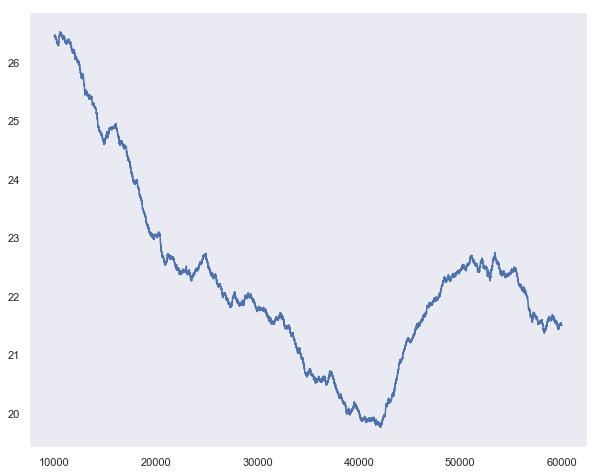

In [12]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

In [13]:
last_10k_train_loss = np.mean(metrics['loss'][-20000:-10000]) 
print('Mean of the loss function on the last 10k TRAIN samples: {:.2f}'.format(last_10k_train_loss))

Mean of the loss function on the last 10k TRAIN samples: 21.51


Question 3: What's the average value of the cost function for the last 10000 examples of the training set?

### Answer(3): 21.74

In [14]:
class LogRegressor():
    def __init__(self, tags): 
        self.__version__ = 'v0.4'
        self._tags = set(tags)
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
    
    def update_vocab(self, words_list):
        for word in words_list:
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        sample_loss = 0
        predicted_tags = None

        for tag in self._tags:
            y = int(tag in tags)
            z = self._b[tag]

            for word in question:
                is_word_unknown = word not in self._vocab
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                
                z += self._w[tag][self._vocab[word]]

            # calculate the probability of tag                 
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            # update the value of the loss function for the current example
            sample_loss += -y*np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                                    -(1 - y)*np.log(1 - np.min([1 - self.tolerance, sigma]))
            if sample_id < self.top_n_train:
                
                dLdw = y - sigma
                delta = self.learning_rate*dLdw
                for word in question:                        
                    self._w[tag][self._vocab[word]] -= -delta
                self._b[tag] -= -delta
            else:
                if predicted_tags is None:
                    predicted_tags = []

                if sigma > self.accuracy_level :
                     predicted_tags.append(tag)

        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        if predicted_tags is not None:
            
            Jaccard = (len(tags.intersection(predicted_tags))/len(tags.union(predicted_tags)))
            
            return pd.Series({'loss': sample_loss, 'Jaccard': Jaccard})
        else:
            return pd.Series({'loss': sample_loss, 'Jaccard': np.NaN})

    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16,
                      accuracy_level=0.9):
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.accuracy_level = accuracy_level
        
        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        self.generate_vocab(df, column_name='question')
        self.show_period = self.total_len // 100
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics

In [15]:
%%time
model = LogRegressor(tags=top_tags)
metrics = model.fit_dataframe(df)

LogRegressor v0.4 | 70000 (100.00%) samples fitted.
Wall time: 2min 49s


In [16]:
metrics.head()

,loss,Jaccard
0,2.4134e-11,nan
1,8.2889,nan
2,5.86224,nan
3,5.80809,nan
4,1.75791,nan


In [17]:
metrics.tail()

,loss,Jaccard
69995,3.04177,0.5
69996,110.315,0
69997,29.9103,0.5
69998,36.8414,0
69999,12.2607,0


In [18]:
accuracy = metrics.loc[60000:].Jaccard.mean()
print('Mean Jaccard accuracy: {:.2f}'.format(accuracy))

Mean Jaccard accuracy: 0.61


### Answer(4): 0.61

In [19]:
class LogRegressor():
    def __init__(self, tags): 
        self.__version__ = 'v0.5'
        self._tags = set(tags)
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
    
    def update_vocab(self, words_list):
        for word in words_list:
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        sample_loss = 0
        predicted_tags = None

        for tag in self._tags:
            y = int(tag in tags)
            z = self._b[tag]

            for word in question:
                is_word_unknown = word not in self._vocab
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                
                z += self._w[tag][self._vocab[word]]

            # calculate the probability of tag                 
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            # update the value of the loss function for the current example
            sample_loss += -y*np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                                    -(1 - y)*np.log(1 - np.min([1 - self.tolerance, sigma]))
            if sample_id < self.top_n_train:
                
                dLdw = y - sigma
                delta = self.learning_rate*dLdw
                for word in question:                        
                    self._w[tag][self._vocab[word]] -= -delta +\
                            self.learning_rate*self.lambda_ *self._w[tag][self._vocab[word]]
                self._b[tag] -= -delta
            else:
                if predicted_tags is None:
                    predicted_tags = []

                if sigma > self.accuracy_level :
                     predicted_tags.append(tag)

        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        if predicted_tags is not None:
            
            Jaccard = (len(tags.intersection(predicted_tags))/len(tags.union(predicted_tags)))
            
            return pd.Series({'loss': sample_loss, 'Jaccard': Jaccard})
        else:
            return pd.Series({'loss': sample_loss, 'Jaccard': np.NaN})

    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16,
                      accuracy_level=0.9,
                      lambda_=0.01):
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.accuracy_level = accuracy_level
        self.lambda_ = lambda_

        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        self.generate_vocab(df, column_name='question')
        self.show_period = self.total_len // 100
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics

In [20]:
%%time
model = LogRegressor(tags=top_tags)
metrics = model.fit_dataframe(df)

LogRegressor v0.5 | 70000 (100.00%) samples fitted.
Wall time: 3min 50s


0.51


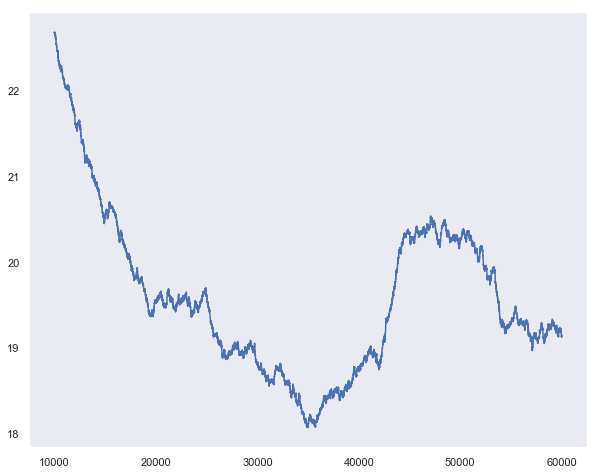

In [21]:
accuracy = metrics.loc[60000:].Jaccard.mean()
print('{:.2f}'.format(accuracy))
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

### Answer(5): 0.48

### Answer(6): 3

In [22]:
class LogRegressor():
    def __init__(self, tags): 
        self.__version__ = 'v0.7'
        self._tags = set(tags)
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
        
    def update_vocab(self, words_list):
        for word in words_list:
            if word not in self._vocab:
                self._vocab[word] = len(self._vocab)
    
    def generate_vocab(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        sample_loss = 0
        predicted_tags = None

        for tag in self._tags:
            y = int(tag in tags)
            z = self._b[tag]

            for word in question:
                is_word_unknown = word not in self._vocab
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                
                z += self._w[tag][self._vocab[word]]

            # calculate the probability of tag                 
            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            # update the value of the loss function for the current example
            sample_loss += -y*np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                                    -(1 - y)*np.log(1 - np.min([1 - self.tolerance, sigma]))
            if sample_id < self.top_n_train:
                
                dLdw = y - sigma
                delta = self.learning_rate*dLdw
                for word in question:                        
                    self._w[tag][self._vocab[word]] -= -delta +\
                            self.learning_rate*self.lambda_ * \
                                            (2 * self.gamma_ * self._w[tag][self._vocab[word]] + \
                                               (1 - self.gamma_) * np.sign(self._w[tag][self._vocab[word]]))
                                             
                self._b[tag] -= -delta
            else:
                if predicted_tags is None:
                    predicted_tags = []

                if sigma > self.accuracy_level :
                     predicted_tags.append(tag)

        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        if predicted_tags is not None:
            
            Jaccard = (len(tags.intersection(predicted_tags))/len(tags.union(predicted_tags)))
            
            return pd.Series({'loss': sample_loss, 'Jaccard': Jaccard})
        else:
            return pd.Series({'loss': sample_loss, 'Jaccard': np.NaN})

    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16,
                      accuracy_level=0.9,
                      lambda_=0.001,
                      gamma_ = 0.1):
                      
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.accuracy_level = accuracy_level
        self.lambda_ = lambda_
        self.gamma_ = gamma_                                                               

        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        self.generate_vocab(df, column_name='question')
        self.show_period = self.total_len // 100
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics        

In [23]:
%%time
model = LogRegressor(tags=top_tags)
metrics = model.fit_dataframe(df)

LogRegressor v0.7 | 70000 (100.00%) samples fitted.
Wall time: 8min 22s


0.59


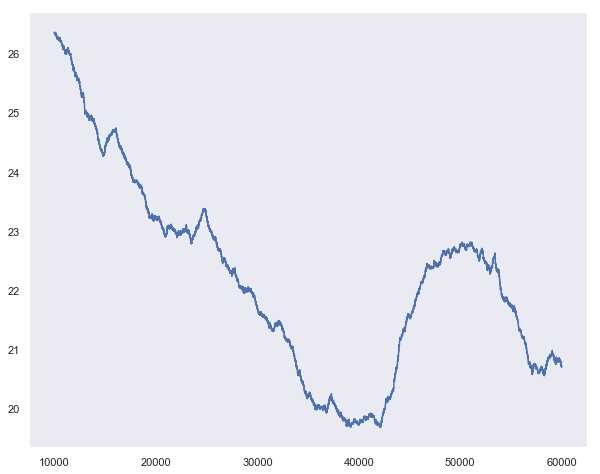

In [24]:
accuracy = metrics.loc[60000:].Jaccard.mean()
print('{:.2f}'.format(accuracy))
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

### Answer(7): 0.61

In [26]:
model._vocab_inv = dict([(v, k) for (k, v) in model._vocab.items()])
top = 5
for tag in model._tags:
    top5_words = [model._vocab_inv[k] for (k, v) in
                  sorted(model._w[tag].items(), key=lambda t: t[1], reverse=True)[:top]]
    print(tag, ':', ', '.join(top5_words))    

ios : ios, dylib, nsstring, nil, corefoundation
javascript : javascript, 125, getelementbyid, li, infowindow
java : java, println, spring, quot, jsp
c# : nbsp, binding, writeline, setter, tostring
html : html, some, span, quot, href
python : python, def, py, np, len
c++ : c++, cout, std, _defaultimage, endl
php : php, x5c, 125, echo, _post
android : android, 08, imgsrv, 29297, 0x0
jquery : jquery, some, ready, ajax, val


### Answer(8): c#.

In [6]:
class LogRegressor():
    def __init__(self, tags): 
        self.__version__ = 'v0.9'
        self._tags = set(tags)
        self._vocab = {}
        self._w = dict([(t, defaultdict(int)) for t in tags])
        self._b = dict([(t, 0) for t in tags])
        self._word_stats = defaultdict(int)
    
    def update_vocab(self, words_list):
        for word in words_list:
            if word not in self._vocab and not self.freeze_vocab:
                    self._vocab[word] = len(self._vocab)
            if word in self._vocab:
                self._word_stats[self._vocab[word]] += 1
    
    def generate_vocab(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError("DataFrame doesnt have '{}' column!")
        df[column_name].map(self.update_vocab)

    def fit_sample(self, sample):
        sample_id = sample.name
        question = sample['question']
        tags = set(sample['tags'])
        sample_loss = 0
        predicted_tags = None

        for tag in self._tags:
            y = int(tag in tags)
            z = self._b[tag]

            for word in question:
                is_word_unknown = word not in self._vocab
                if sample_id >= self.top_n_train and is_word_unknown:
                    continue
                if word in self._vocab:
                    z += self._w[tag][self._vocab[word]] 
            

            sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
            
            sample_loss += -y*np.log(np.max([self.tolerance, sigma])) if y == 1 else \
                                    -(1 - y)*np.log(1 - np.min([1 - self.tolerance, sigma]))

            if sample_id < self.top_n_train:
                # HERE'S YOUR CODE
                dLdw = y - sigma

                delta = self.learning_rate*dLdw
                for word in question:
                    if word in self._vocab:
                        self._w[tag][self._vocab[word]] -= -delta +\
                            self.learning_rate*self.lambda_ * \
                                            (2 * self.gamma_ * self._w[tag][self._vocab[word]] + \
                                               (1 - self.gamma_) * np.sign(self._w[tag][self._vocab[word]]))
                self._b[tag] -= -delta
            else:
                if predicted_tags is None:
                    predicted_tags = []
                # HERE'S YOUR CODE
                if sigma > self.accuracy_level:
                    predicted_tags.append(tag)

        if sample_id % self.show_period == 0:
            n = sample_id + self.show_period
            clear_output(wait=True)
            print('LogRegressor {} | {} ({:.2f}%) samples fitted.'.format(
                self.__version__,
                n, 
                100 * n / self.total_len))
        if predicted_tags is not None:
            # HERE'S YOUR CODE
            Jaccard = (len(tags.intersection(predicted_tags))/len(tags.union(predicted_tags)))
            return pd.Series({'loss': sample_loss, 'Jaccard': Jaccard})
        else:
            return pd.Series({'loss': sample_loss, 'Jaccard': np.NaN})

    
    def fit_dataframe(self, 
                      df,
                      top_n_train=60000, 
                      learning_rate=0.1,
                      tolerance=1e-16,
                      accuracy_level=0.9,
                      lambda_=0.001,
                      gamma_=0.1,
                      freeze_vocab = False):
        self.total_len = df.shape[0]
        self.top_n_train = top_n_train
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.accuracy_level = accuracy_level
        self.lambda_ = lambda_
        self.gamma_ = gamma_
        self.freeze_vocab = freeze_vocab
        if self.top_n_train > self.total_len:
            print("Warning! 'top_n_train' more than dataframe rows count!\n"
                  "Set default 'top_n_train'=60000")
            self.top_n_train = 60000
        
        self.generate_vocab(df, column_name='question')
        self.show_period = self.total_len // 100
        self.metrics = df.apply(self.fit_sample, axis=1)
        return self.metrics
    
    def filter_vocab(self, n=10000):
        keep_words = set([wid for (wid, wn) in sorted(self._word_stats.items(), 
                                                      key=lambda t: t[1], reverse=True)[:n]])
        self._vocab = dict([(k, v) for (k, v) in self._vocab.items() if v in keep_words])
        for tag in self._tags:
            self._w[tag] = dict([(k, v) for (k, v) in self._w[tag].items() if k in keep_words])

LogRegressor v0.9 | 70000 (100.00%) samples fitted.
loss        25.877
Jaccard   0.584792
dtype: float64
Mean Jaccard accuracy: 0.58
Wall time: 7min 54s


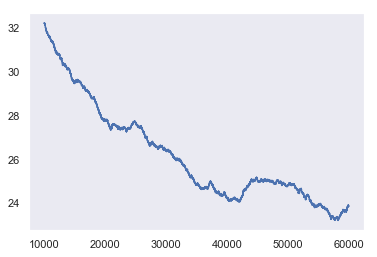

In [7]:
%%time
model = LogRegressor(tags=top_tags)
metrics = model.fit_dataframe(df, learning_rate=0.2)
print(np.mean(metrics))
accuracy = metrics.loc[60000:].Jaccard.mean()
print('Mean Jaccard accuracy: {:.2f}'.format(accuracy))
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

In [29]:
model.filter_vocab(n=10000)

LogRegressor v0.9 | 70000 (100.00%) samples fitted.
loss        16.873
Jaccard   0.670978
dtype: float64
Mean Jaccard accuracy: 0.67
Wall time: 6min 57s


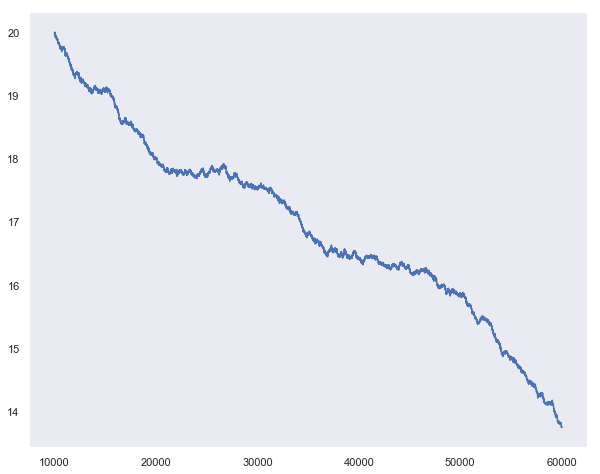

In [30]:
%%time
metrics = model.fit_dataframe(df, learning_rate=0.01, lambda_ = 0.0002, freeze_vocab = True)
print(np.mean(metrics))
accuracy = metrics.loc[60000:].Jaccard.mean()
print('Mean Jaccard accuracy: {:.2f}'.format(accuracy))
plot = plt.plot(pd.Series(metrics['loss'][:-10000]).rolling(10000).mean())

### Answer(9): 0.66

In [51]:
def predict_proba(model, sentence):
    # HERE'S YOUR CODE
    
    word_list = sentence.split(' ')
    tag_list = []
    for tag in model._tags:
        z = model._b[tag]
            
        for word in word_list:
            if word not in model._vocab:
                continue
            z += model._w[tag][model._vocab[word]] 
            
        sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
        print(tag, sigma,z)
        if sigma>=0.9:
            tag_list.append(tag)
    
    return tag_list

In [8]:
def predict_proba(model, sentence):
    p = {}
    sentence = sentence.lower().split(' ')
    for tag in model._tags:
        z = model._b[tag]
        for word in sentence:
            if word not in model._vocab:
                continue
            z += model._w[tag][model._vocab[word]]
        sigma = 1/(1 + np.exp(-z)) if z >= 0 else 1 - 1/(1 + np.exp(z))
        p[tag] = sigma
    return p

In [9]:
sentence = ("I want to improve my coding skills, so I have planned write " +
            "a Mobile Application.need to choose between Apple's iOS or Google's Android." +
            " my background: I have done basic programming in .Net,C/C++,Python and PHP " +
            "in college, so got OOP concepts covered. about my skill level, I just know " +
            "concepts and basic syntax. But can't write complex applications, if asked :(" +
            " So decided to hone my skills, And I wanted to know which is easier to " +
            "learn for a programming n00b. A) iOS which uses Objective C B) Android " + 
            "which uses Java. I want to decide based on difficulty level")

In [11]:
pred = predict_proba(model, sentence.lower().replace(',', ''))

In [12]:
tag_preds = sorted(pred.items(), key=lambda t: t[1], reverse=True)

In [13]:
list(filter(lambda t: t[1] > 0.9, tag_preds))

[('ios', 1.0), ('php', 0.9999999999999938)]

### Answer(10): ios, php